In [1]:
import os
import subprocess
from glob import glob
import urllib

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.image as mpimg
import cartopy.crs as ccrs

In [2]:
url = 'https://www.st.nmfs.noaa.gov/copepod/biomass/copepod-2012__biomass-fields.zip'

local_file = 'data/orig/copepod-2012__biomass-fields.zip'
os.makedirs(os.path.dirname(local_file), exist_ok=True)
if not os.path.exists('data/orig/copepod-2012__biomass-fields'):
    urllib.request.urlretrieve(url, local_file)
    subprocess.run(['unzip', '-d', 'data/orig', local_file])

In [3]:
files_csv = sorted(glob('data/orig/copepod-2012__biomass-fields/data/copepod-2012__cmass-m??-qtr.csv'))
files_jpg = sorted(glob('data/orig/copepod-2012__biomass-fields/images/copepod-2012__cmass-m??.jpg'))
files_csv

['data/orig/copepod-2012__biomass-fields/data/copepod-2012__cmass-m00-qtr.csv',
 'data/orig/copepod-2012__biomass-fields/data/copepod-2012__cmass-m01-qtr.csv',
 'data/orig/copepod-2012__biomass-fields/data/copepod-2012__cmass-m02-qtr.csv',
 'data/orig/copepod-2012__biomass-fields/data/copepod-2012__cmass-m03-qtr.csv',
 'data/orig/copepod-2012__biomass-fields/data/copepod-2012__cmass-m04-qtr.csv',
 'data/orig/copepod-2012__biomass-fields/data/copepod-2012__cmass-m05-qtr.csv',
 'data/orig/copepod-2012__biomass-fields/data/copepod-2012__cmass-m06-qtr.csv',
 'data/orig/copepod-2012__biomass-fields/data/copepod-2012__cmass-m07-qtr.csv',
 'data/orig/copepod-2012__biomass-fields/data/copepod-2012__cmass-m08-qtr.csv',
 'data/orig/copepod-2012__biomass-fields/data/copepod-2012__cmass-m09-qtr.csv',
 'data/orig/copepod-2012__biomass-fields/data/copepod-2012__cmass-m10-qtr.csv',
 'data/orig/copepod-2012__biomass-fields/data/copepod-2012__cmass-m11-qtr.csv',
 'data/orig/copepod-2012__biomass-fields

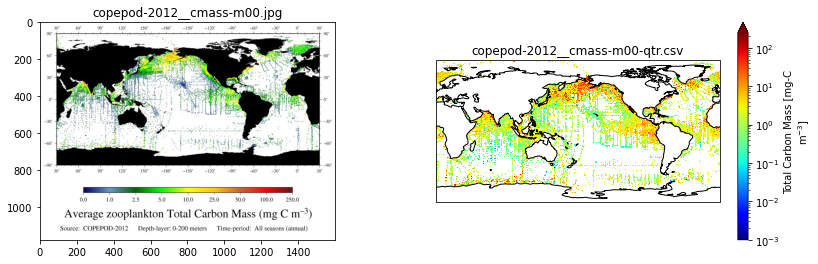

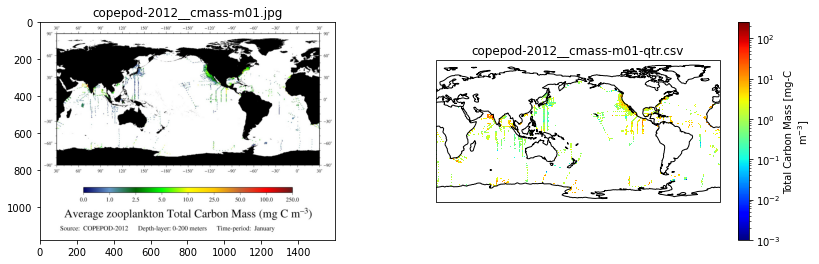

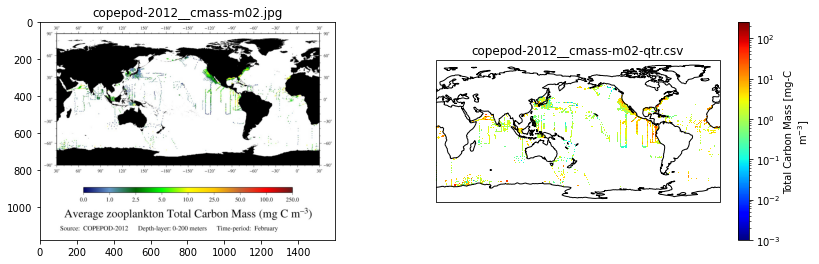

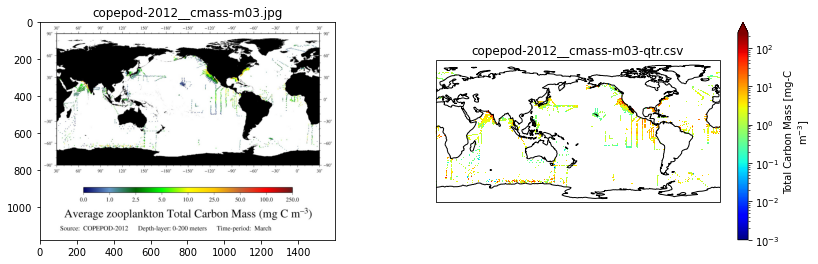

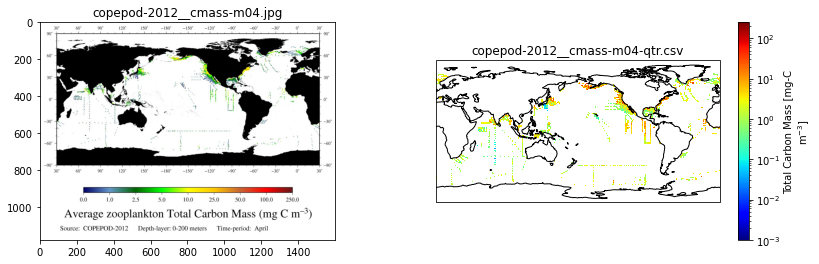

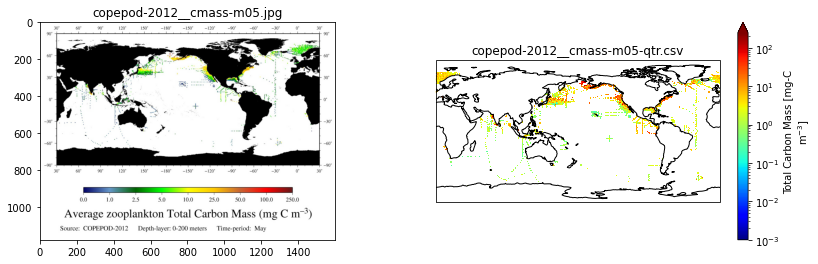

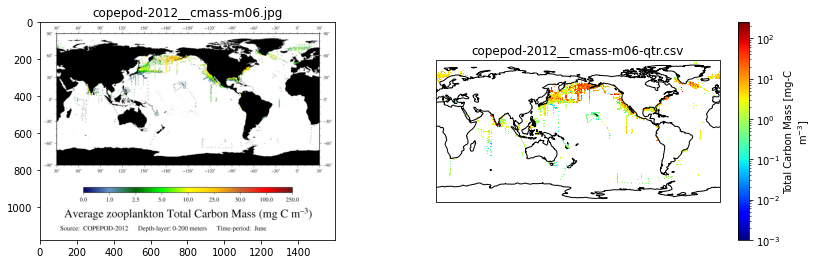

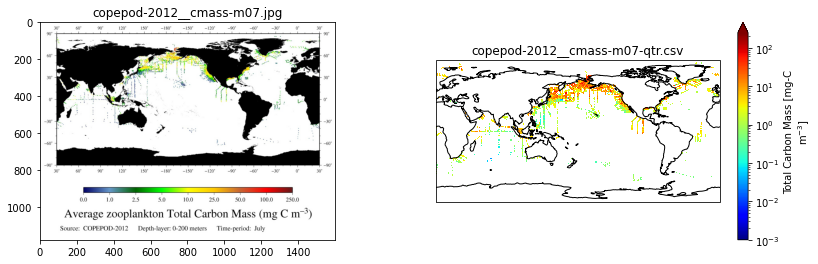

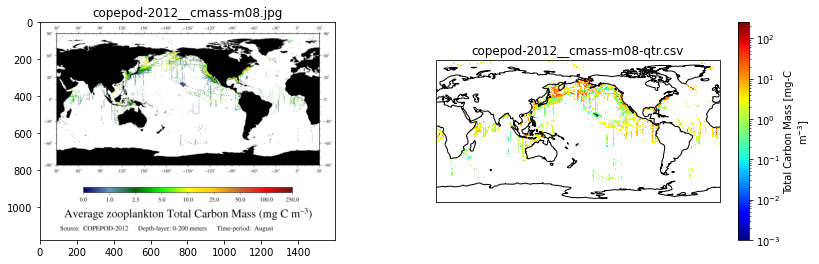

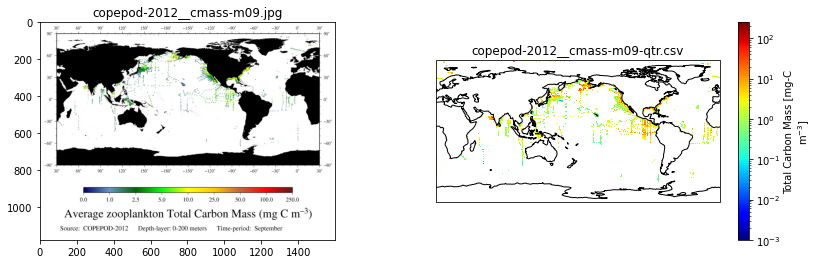

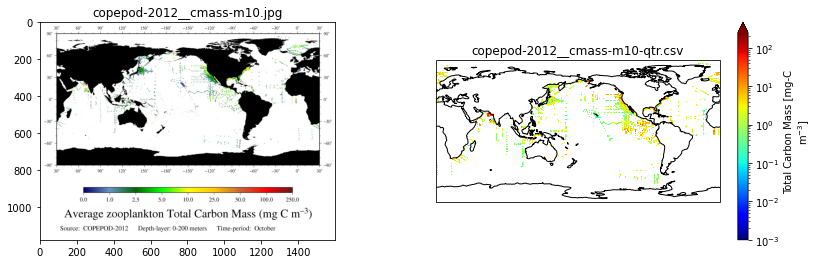

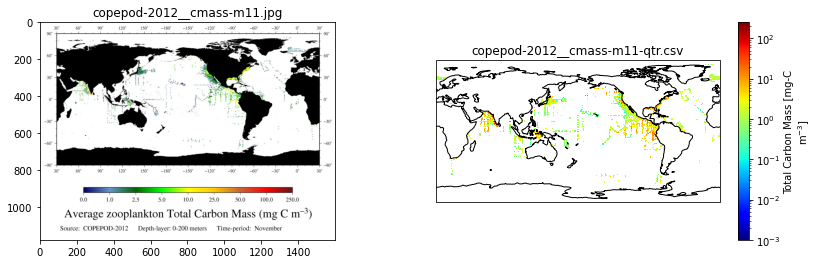

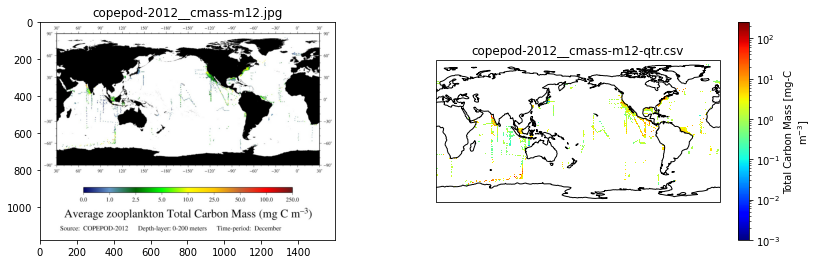

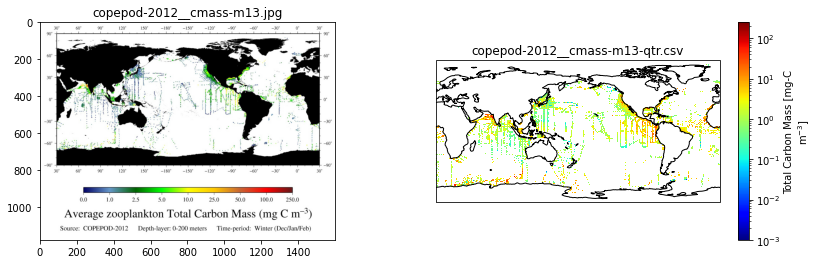

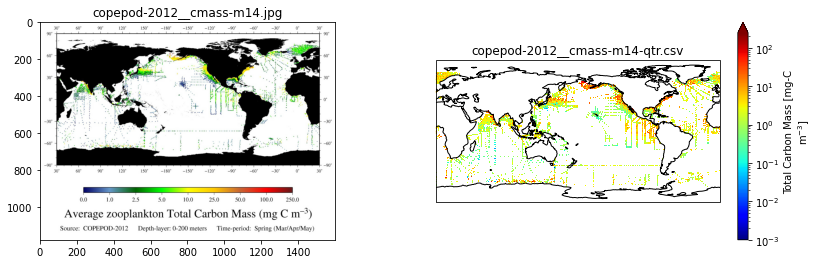

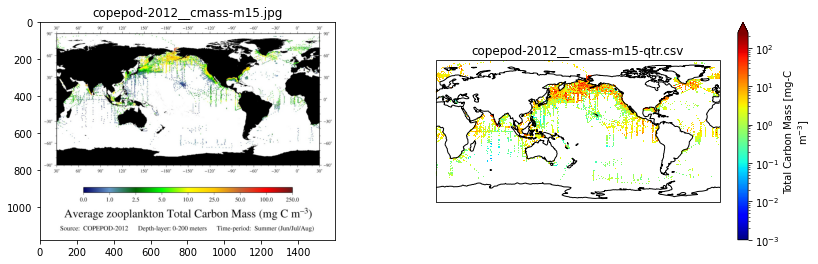

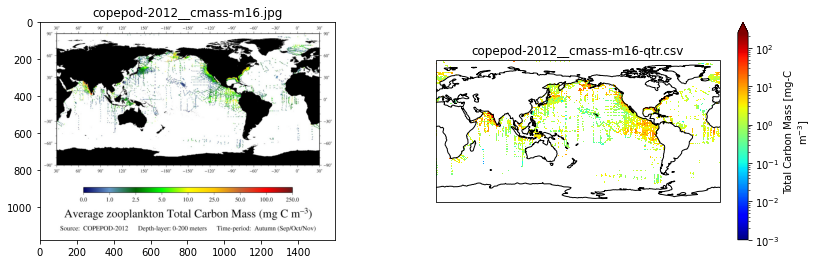

In [4]:
def csv2nc(f):
    """Convert csv file to Xarray dataset"""
    lon = xr.DataArray(np.arange(-180 + 0.125, 180., 0.25), dims=('lon'), name='lon')
    lat = xr.DataArray(np.arange(-90 + 0.125, 90., 0.25), dims=('lat'), name='lat')

    rename_dict = {
        'Longitude': 'lon', 
        'Latitude': 'lat', 
        'Total Carbon Mass (mg-C/m3)': 'copepod_C',
        'n': 'n_obs',
    }
    attrs = dict(
        copepod_C=dict(
            units='mg-C m$^{-3}$',
            long_name='Total Carbon Mass',
        )
    )
    
    keep_vars = list(rename_dict.values())
    
    df = pd.read_csv(f).rename(rename_dict, axis=1)[keep_vars].set_index(['lon', 'lat'])
    _, ds = xr.align(xr.Dataset(dict(lon=lon, lat=lat)), df.to_xarray(), join='outer')
    
    for v in attrs:
        ds[v].attrs = attrs[v]    
    
    ds.attrs['file_in'] = f
    return ds.transpose('lat', 'lon')

dirout = 'data/0_25x0_25'
os.makedirs(dirout, exist_ok=True)

clobber = True

for file_csv, file_jpg in zip(files_csv, files_jpg):
    file_zarr = f"{dirout}/{os.path.basename(file_csv).replace('csv', 'zarr')}"

    ds = csv2nc(file_csv)
    img = mpimg.imread(file_jpg)
    if not os.path.exists(file_zarr) or clobber:        
        ds.to_zarr(file_zarr, mode='w')

    fig = plt.figure(figsize=(14, 4))
    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2, projection=ccrs.PlateCarree(central_longitude=180))
    
    img = mpimg.imread(file_jpg)
    ax1.imshow(img)
    ax1.set_title(os.path.basename(file_jpg))
    
    ds.copepod_C.plot(
        ax=ax2, 
        norm=colors.LogNorm(vmin=1e-3, vmax=250.),
        transform=ccrs.PlateCarree(),
        cmap='jet',
    )
    ax2.coastlines()
    ax2.set_title(os.path.basename(file_csv))
